In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from statsmodels.stats.proportion import proportions_ztest
# from statsmodels.stats.proportion import proportions_chisquare
from IPython.display import display, HTML
from scipy.stats import kruskal
import seaborn as sns
from scipy.stats import mannwhitneyu

import sys
import logging
logging.basicConfig(level=logging.CRITICAL)

from pytqs import tqs
import bytedtqs
from datetime import date, timedelta

In [2]:
# appId = "eL38NWjpAMXlC0ifCoo71wk27zE6CS9YQismEcwVH5oNKbJf"
# appKey = "VeeOKtXLxjGWE2OyIGkuqWRT33isyxtHH1xlxakeFzId6SMB"
# user_id = 'wuweiwei.1012'

In [3]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

### 获取实验数据

In [25]:
all_data = pd.read_csv('/home/tiger/archived-data/aeolus-data/20210603/10/281474977433616-课程实验-兴趣课-查询3.csv')

In [26]:
all_data.head()

,abtest_dt,user_group,user_id,enter_camp_user,enter_group_user,d6_vip_user,mile_stone_name,d0_finish_lessons,d0_study_duration,d1_study_duration,d2_study_duration,d3_study_duration,d4_study_duration,d5_study_duration,d6_study_duration,d7_study_duration,d14_study_duration,rank_normalization,rank_group
0,2021-05-16,对照组,1970780405506067,1,1,1,A2高,2,671,2237,1574,1773,1895,1850,1060,2061,1381,0.604106,3_中绩效
1,2021-05-27,实验组,3114276260417216,0,0,1,NaN,0,0,3985,1999,4888,2874,0,5227,0,0,NaN,NaN
2,2021-05-20,对照组,3131865959507632,1,0,0,B2,0,877,0,0,0,0,0,0,0,0,NaN,NaN
3,2021-05-17,实验组,88416834035895,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN
4,2021-05-22,实验组,211563708157719,0,0,1,A1初,2,1714,0,0,2217,680,979,666,1810,0,NaN,NaN


In [27]:
all_data.rename(columns={'user_type':'user_group'}, inplace=True)

In [28]:
len(all_data)

69866

In [29]:
all_data.columns

Index(['abtest_dt', 'user_group', 'user_id', 'enter_camp_user',
       'enter_group_user', 'd6_vip_user', 'mile_stone_name',
       'd0_finish_lessons', 'd0_study_duration', 'd1_study_duration',
       'd2_study_duration', 'd3_study_duration', 'd4_study_duration',
       'd5_study_duration', 'd6_study_duration', 'd7_study_duration',
       'd14_study_duration', 'rank_normalization', 'rank_group'],
      dtype='object')

In [30]:
### 预处理数据
df_raw = all_data

#1. 填充空值数据
category_cols = []

for c in df_raw.columns:
    if df_raw[c].dtype=='O':
        df_raw[c] = df_raw[c].fillna('unknown')
        category_cols.append(c)
    else:
        df_raw[c] = df_raw[c].fillna(0)
        
#2. 合并数据
# df_raw['first_level_name'].replace({"A0+": "A0", "A0-": "A0"}, inplace=True)

In [134]:
#2. 增加新字段

# all_data = all_data[~all_data.milestone_name.isin(['未定级'])]

df_raw.loc[(df_raw['d5_year_total_cnt'] > 0), 'd5_year_yn'] = 1
df_raw.loc[(df_raw['d5_year_total_cnt'] == 0), 'd5_year_yn'] = 0
df_raw.loc[(df_raw['d8_year_total_cnt'] > 0), 'd8_year_yn'] = 1
df_raw.loc[(df_raw['d8_year_total_cnt'] == 0), 'd8_year_yn'] = 0
df_raw.loc[(df_raw['d18_year_total_cnt'] > 0), 'd18_year_yn'] = 1
df_raw.loc[(df_raw['d18_year_total_cnt'] == 0), 'd18_year_yn'] = 0

df_raw.loc[(df_raw['d5_hiarpu_total_cnt'] > 0), 'd5_hiarpu_yn'] = 1
df_raw.loc[(df_raw['d5_hiarpu_total_cnt'] == 0), 'd5_hiarpu_yn'] = 0
df_raw.loc[(df_raw['d8_hiarpu_total_cnt'] > 0), 'd8_hiarpu_yn'] = 1
df_raw.loc[(df_raw['d8_hiarpu_total_cnt'] == 0), 'd8_hiarpu_yn'] = 0
df_raw.loc[(df_raw['d18_hiarpu_total_cnt'] > 0), 'd18_hiarpu_yn'] = 1
df_raw.loc[(df_raw['d18_hiarpu_total_cnt'] == 0), 'd18_hiarpu_yn'] = 0

df_raw.loc[(df_raw['d5_total_cnt'] > 0), 'd5_total_yn'] = 1
df_raw.loc[(df_raw['d5_total_cnt'] == 0), 'd5_total_yn'] = 0
df_raw.loc[(df_raw['d8_total_cnt'] > 0), 'd8_total_yn'] = 1
df_raw.loc[(df_raw['d8_total_cnt'] == 0), 'd8_total_yn'] = 0
df_raw.loc[(df_raw['d18_total_cnt'] > 0), 'd18_total_yn'] = 1
df_raw.loc[(df_raw['d18_total_cnt'] == 0), 'd18_total_yn'] = 0

# review_test_data.head()


In [31]:
# all_data.loc[all_data.user_group == '实验组', 'rank_normalization'].max()

0.9850746268656716

### 分组合理性

In [38]:
# compare samples
df_raw_camp = df_raw[df_raw.enter_camp_user == 1]

test_data = df_raw_camp.loc[df_raw_camp.user_group == '实验组', 'rank_normalization']
ctrl_data = df_raw_camp.loc[df_raw_camp.user_group == '对照组', 'rank_normalization']

stat, p = mannwhitneyu(test_data, ctrl_data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=97583329.500, p=0.223
Same distribution (fail to reject H0)


In [39]:
df_raw_camp.groupby(df_raw_camp.user_group)[['rank_normalization']].mean().reset_index()

,user_group,rank_normalization
0,实验组,0.119243
1,对照组,0.117360


In [40]:
df_raw_camp.groupby(df_raw_camp.user_group)[['rank_normalization']].median().reset_index()

,user_group,rank_normalization
0,实验组,0.0
1,对照组,0.0


/home/tiger/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tiger/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

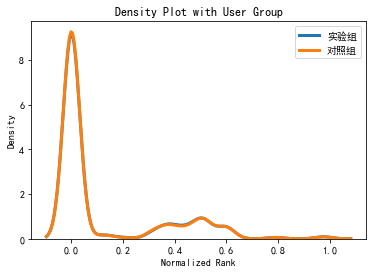

In [41]:
user_group_list = ['实验组', '对照组']

for user_group in user_group_list:
    subset = df_raw_camp.loc[df_raw_camp.user_group == user_group]
    
    # Draw the density plot
    sns.distplot(subset['rank_normalization'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = user_group)
    
# Plot formatting
plt.legend(prop={'size': 10})
plt.title('Density Plot with User Group')
plt.xlabel('Normalized Rank')
plt.ylabel('Density')

### 实验数据

In [145]:
conv_var = [
    'd8_year_yn',
    'd18_year_yn',
    'd8_hiarpu_yn',
    'd18_hiarpu_yn',
    'd8_total_yn',
    'd18_total_yn',
]

mean_var = [
    'd8_year_order_revenue',
    'd18_year_order_revenue',
    'd8_hiarpu_order_revenue',
    'd18_hiarpu_order_revenue',
    'd8_order_revenue',
    'd18_order_revenue',
    'd5_study_day',
    'd8_study_day',
    'd18_study_day',
    'd5_study_mins',
    'd8_study_mins',
    'd18_study_mins',
]

In [146]:
def ab_summary_data(data, user_group):
    test_summary = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value","Significance"])
    
    test_data = data.loc[data.user_group == '实验群']
    ctrl_data = data.loc[data.user_group == '对照组']

    dnu_t = len(test_data)
    dnu_c = len(ctrl_data)

    # 新增用户
    test_summary = test_summary.append({"Metrics": '实验用户', "Control": '{:,}'.format(dnu_c), "Test": '{:,}'.format(dnu_t), "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)


    # Proportion 
    for _var in conv_var:
        conv_t = sum(test_data[_var])
        conv_c = sum(ctrl_data[_var])

        rate_t = round(conv_t / dnu_t, 4)
        rate_c = round(conv_c / dnu_c, 4)

        delta = rate_t / rate_c - 1 if rate_c > 0 else np.nan
        p_value = two_proprotions_test(conv_t, dnu_t, conv_c, dnu_c)[1]
        sig =  "Significant" if p_value < 0.05 else "Non-significant"
        test_summary = test_summary.append({"Metrics": _var, "Control": "{:.2%}".format(rate_c), "Test": "{:.2%}".format(rate_t), "Delta": "{:.2%}".format(delta), "p_value": round(p_value, 4), "Significance": sig}, ignore_index = True)

        test_summary['User_Group'] = user_group
    
    # mean 
    for _var in mean_var:
        conv_t = sum(test_data[_var])
        conv_c = sum(ctrl_data[_var])

        rate_t = round(conv_t / dnu_t, 4)
        rate_c = round(conv_c / dnu_c, 4)

        delta = rate_t / rate_c - 1 if rate_c > 0 else np.nan
        p_value = two_proprotions_test(conv_t, dnu_t, conv_c, dnu_c)[1]
        p_value = stats.ttest_ind(test_data[_var], ctrl_data[_var], equal_var = False).pvalue
        
        sig =  "Significant" if p_value < 0.05 else "Non-significant"
        test_summary = test_summary.append({"Metrics": _var, "Control": "{:.2f}".format(rate_c), "Test": "{:.2f}".format(rate_t), "Delta": "{:.2%}".format(delta), "p_value": round(p_value, 4), "Significance": sig}, ignore_index = True)

        test_summary['User_Group'] = user_group
    
    return test_summary

#### 全量用户

In [147]:
test_cntrl_data = df_raw

output = ab_summary_data(test_cntrl_data, '全量用户')
output.style.apply(lambda x: ["background: green" if v == 'Significant' else "" for v in x], axis = 1).hide_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


User_Group,Metrics,Control,Test,Delta,p_value,Significance
全量用户,实验用户,"3,937","4,783",-,-,-
全量用户,d8_year_yn,0.99%,0.50%,-49.49%,0.007300,Significant
全量用户,d18_year_yn,12.19%,13.55%,11.16%,0.060400,Non-significant
全量用户,d8_hiarpu_yn,3.48%,3.85%,10.63%,0.364900,Non-significant
全量用户,d18_hiarpu_yn,4.09%,4.47%,9.29%,0.378100,Non-significant
全量用户,d8_total_yn,4.37%,4.33%,-0.92%,0.925600,Non-significant
全量用户,d18_total_yn,15.75%,17.21%,9.27%,0.068100,Non-significant
全量用户,d8_year_order_revenue,8.99,4.53,-49.56%,0.012700,Significant
全量用户,d18_year_order_revenue,112.30,124.46,10.83%,0.072900,Non-significant
全量用户,d8_hiarpu_order_revenue,89.25,97.18,8.89%,0.444600,Non-significant


#### 维度细分

In [148]:
dim_var =  [
    'group_yn',
    'first_level_name',
    'occupation',
    'rank_group',
]

In [149]:
output = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value","Significance"])

for _var in dim_var:
    group_list = sorted(df_raw[_var].unique().tolist())
    
    for i in range(0,len(group_list)):
        user_group = group_list[i]
        group_data = df_raw[df_raw[_var] == user_group]
        output = output.append(ab_summary_data(group_data, user_group))

output.reset_index(drop=True).style.apply(lambda x: ["background: green" if v == 'Significant' else "" for v in x], axis = 1).hide_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


User_Group,Metrics,Control,Test,Delta,p_value,Significance
0.000000,实验用户,776,"1,001",-,-,-
0.000000,d8_year_yn,0.13%,0.10%,-23.08%,0.856700,Non-significant
0.000000,d18_year_yn,0.77%,0.70%,-9.09%,0.856100,Non-significant
0.000000,d8_hiarpu_yn,0.13%,0.10%,-23.08%,0.856700,Non-significant
0.000000,d18_hiarpu_yn,0.13%,0.10%,-23.08%,0.856700,Non-significant
0.000000,d8_total_yn,0.26%,0.20%,-23.08%,0.798300,Non-significant
0.000000,d18_total_yn,0.90%,0.70%,-22.22%,0.631600,Non-significant
0.000000,d8_year_order_revenue,1.16,0.90,-22.48%,0.859000,Non-significant
0.000000,d18_year_order_revenue,5.04,6.47,28.46%,0.662000,Non-significant
0.000000,d8_hiarpu_order_revenue,3.22,2.50,-22.48%,0.859000,Non-significant


#### 群内维度细分

In [150]:
dim_var =  [
    'first_level_name',
    'occupation',
    'rank_group',
]

output = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value","Significance"])

for _var in dim_var:
    group_list = sorted(df_raw[_var].unique().tolist())
    
    for i in range(0,len(group_list)):
        user_group = group_list[i]
        group_data = df_raw[(df_raw[_var] == user_group) & (df_raw['group_yn'] == 1)]
        output = output.append(ab_summary_data(group_data, user_group))

output.reset_index(drop=True).style.apply(lambda x: ["background: green" if v == 'Significant' else "" for v in x], axis = 1).hide_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launc

User_Group,Metrics,Control,Test,Delta,p_value,Significance
A0,实验用户,192,213,-,-,-
A0,d8_year_yn,1.04%,0.47%,-54.81%,0.502500,Non-significant
A0,d18_year_yn,8.85%,10.33%,16.72%,0.615500,Non-significant
A0,d8_hiarpu_yn,4.17%,2.82%,-32.37%,0.457800,Non-significant
A0,d18_hiarpu_yn,6.25%,2.82%,-54.88%,0.094100,Non-significant
A0,d8_total_yn,5.21%,3.29%,-36.85%,0.335500,Non-significant
A0,d18_total_yn,15.10%,12.68%,-16.03%,0.479700,Non-significant
A0,d8_year_order_revenue,8.52,4.22,-50.52%,0.558000,Non-significant
A0,d18_year_order_revenue,76.54,91.30,19.28%,0.567100,Non-significant
A0,d8_hiarpu_order_revenue,104.12,70.39,-32.39%,0.463400,Non-significant
